<a href="https://colab.research.google.com/github/Mehtabwho/CSE-Lab-Courses/blob/main/7th-sem%20/ML_LAB/%20ML_Project_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the necessary Libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os

# Pneumonia DataSet

In [25]:
labels = ['PNEUMONIA','NORMAL']
img_resize = 150

def get_data(dir):
  data = []
  for label in labels:
    path = os.path.join(dir, label)
    class_num = labels.index(label)

    for img in os.listdir(path):
      try:
        if img.endswith('jpeg'):
          img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
          resized_arr = cv2.resize(img_arr, (img_resize, img_resize))
          data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data,dtype= 'object')




In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
train = get_data('/content/drive/MyDrive/Machine learning lab/X-ray/train')
test = get_data('/content/drive/MyDrive/Machine learning lab/X-ray/test')
val = get_data('/content/drive/MyDrive/Machine learning lab/X-ray/val')

## Data Visualization and Preprocessing

<Axes: xlabel='count'>

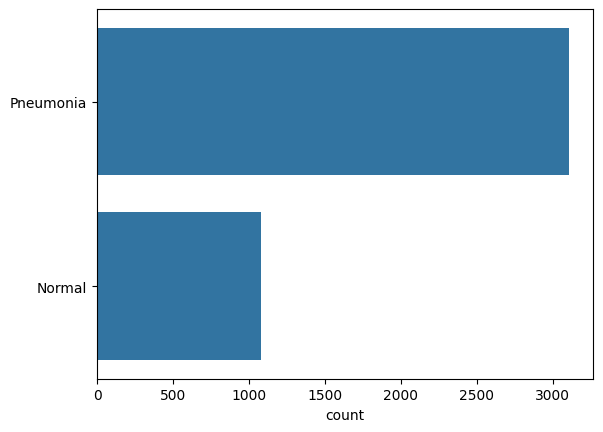

In [28]:
l = []
for i in train:
  if (i[1] == 0):
    l.append('Pneumonia')
  else:
    l.append('Normal')

sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

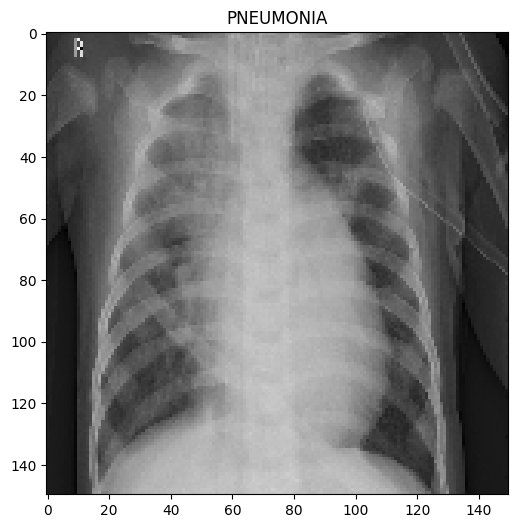

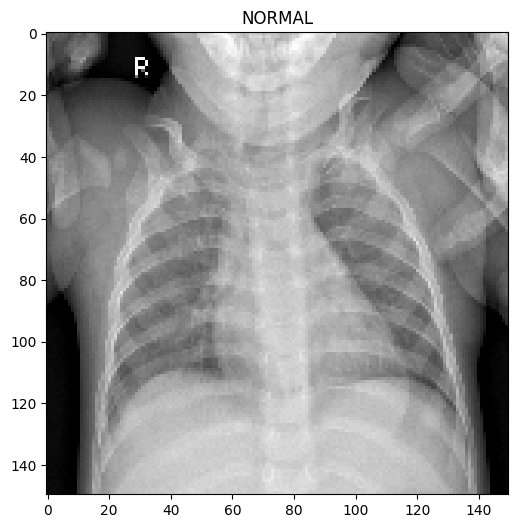

In [29]:
plt.figure(figsize=(6,6))

plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(6,6))

plt.imshow(train[-11][0], cmap='gray')
plt.title(labels[train[-11][1]])

In [30]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feat, label in train:
  x_train.append(feat)
  y_train.append(label)

for feat,label in val:
  x_val.append(feat)
  y_val.append(label)

for feat, label in test:
  x_test.append(feat)
  y_test.append(label)

In [31]:
#Normalize the data
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [32]:
x_train

array([[[0.16078431, 0.17254902, 0.19215686, ..., 0.04313725,
         0.04705882, 0.04705882],
        [0.16862745, 0.17647059, 0.18039216, ..., 0.03529412,
         0.03921569, 0.03921569],
        [0.16078431, 0.16862745, 0.18823529, ..., 0.01568627,
         0.03137255, 0.03529412],
        ...,
        [0.11372549, 0.10980392, 0.10980392, ..., 0.10196078,
         0.10196078, 0.10196078],
        [0.11372549, 0.10980392, 0.10980392, ..., 0.10196078,
         0.10196078, 0.10196078],
        [0.11372549, 0.10980392, 0.10980392, ..., 0.10196078,
         0.10196078, 0.10196078]],

       [[0.76078431, 0.74509804, 0.71372549, ..., 0.11372549,
         0.10196078, 0.08235294],
        [0.70980392, 0.74901961, 0.77254902, ..., 0.11372549,
         0.10196078, 0.08235294],
        [0.7372549 , 0.74901961, 0.79215686, ..., 0.11764706,
         0.10588235, 0.08627451],
        ...,
        [0.50588235, 0.41960784, 0.41568627, ..., 0.0627451 ,
         0.0627451 , 0.0627451 ],
        [0.4

In [33]:
x_train = x_train.reshape(-1,img_resize, img_resize,1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1,img_resize,img_resize,1)
y_val = np.array(y_val)


x_test = x_test.reshape(-1,img_resize,img_resize,1)
y_test = np.array(y_test)

In [34]:
from sklearn.utils import class_weight

# 1. Calculate weights based on your training data
# "balanced" automatically adjusts weights inversely proportional to class frequencies
weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# 2. Convert to a dictionary
class_weights = dict(enumerate(weights_values))

print("Weights calculated:", class_weights)

Weights calculated: {0: np.float64(0.6739549839228296), 1: np.float64(1.9371534195933457)}


In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow(
    x_train, y_train, batch_size=32, shuffle=True
)

# VALIDATION — NO AUGMENTATION
val_datagen = ImageDataGenerator()   # no rescale
val_gen = val_datagen.flow(
    x_val, y_val, batch_size=32, shuffle=False
)

#Training the model

In [37]:
from keras.optimizers import Adam
model = Sequential()
model.add(Conv2D(32,(3,3), strides =1, padding='same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64,(3,3), strides =1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(128,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(256,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [38]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.3,min_lr=0.000001)

In [39]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    class_weight=class_weights,
    callbacks=[learning_rate_reduction]
)


Epoch 1/12


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.8115 - loss: 0.4229 - val_accuracy: 0.7433 - val_loss: 1.3705 - learning_rate: 1.0000e-04
Epoch 2/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8875 - loss: 0.2570 - val_accuracy: 0.7433 - val_loss: 2.2871 - learning_rate: 1.0000e-04
Epoch 3/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9089 - loss: 0.1981
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9089 - loss: 0.1982 - val_accuracy: 0.7433 - val_loss: 1.7190 - learning_rate: 1.0000e-04
Epoch 4/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9085 - loss: 0.2118 - val_accuracy: 0.7471 - val_loss: 0.9242 - learning_rate: 3.0000e-05
Epoch 5/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9205 - loss: 0.1795 - val_accuracy: 0.9413 - val_loss: 0.2056 - learning_rate: 3.0000e-05
Epoch 6/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.93

In [40]:
model.evaluate(x_test,y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9223 - loss: 0.1808


[0.22914665937423706, 0.9070512652397156]

In [41]:
print(f"Loss of the model is {model.evaluate(x_test,y_test)[0]}")
print(f"Accuracy of the model is {model.evaluate(x_test,y_test)[1]*100} %")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9223 - loss: 0.1808
Loss of the model is 0.22914665937423706
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9223 - loss: 0.1808
Accuracy of the model is 90.70512652397156 %


# Analyse Model Performance

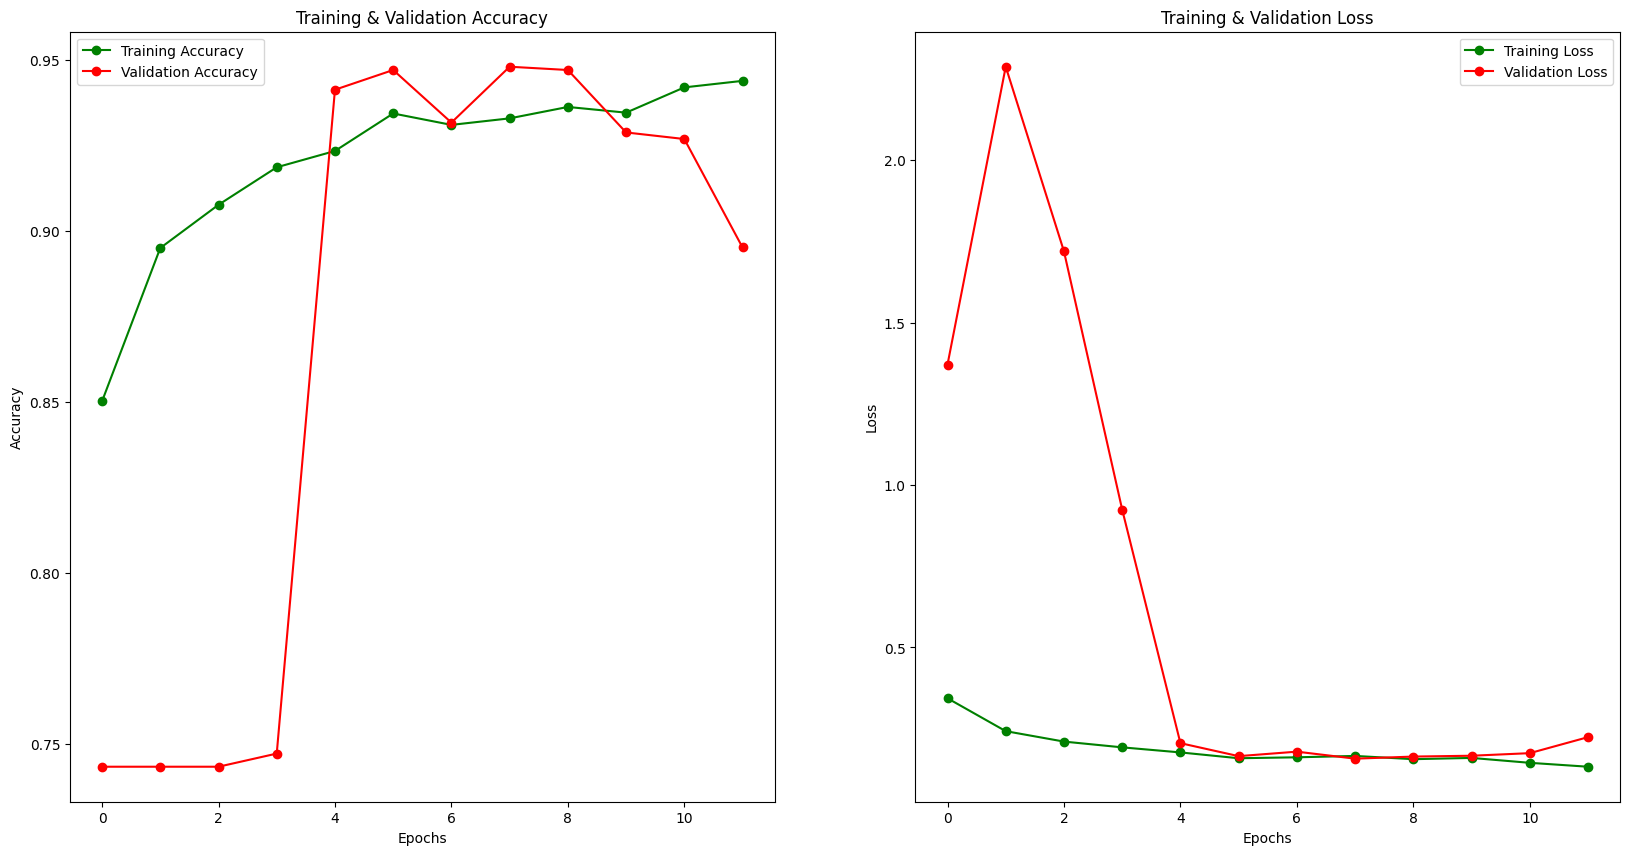

In [42]:
epochs = [i for i in range(len(history.history['accuracy']))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')


ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()

In [43]:
predictions = (model.predict(x_test) > 0.5).astype('int32')
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [44]:
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.92      0.93       390
   Normal (Class 1)       0.87      0.88      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [45]:
cm = confusion_matrix(y_test,predictions)

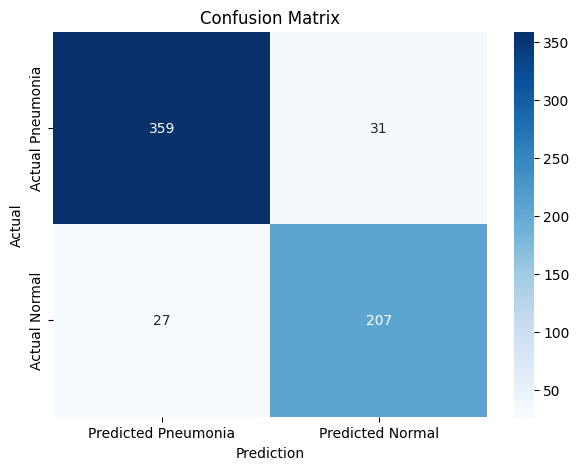

In [47]:
cm

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Pneumonia', 'Predicted Normal'],
            yticklabels=['Actual Pneumonia', 'Actual Normal'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [48]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

#Some Correctly Predicted Classes

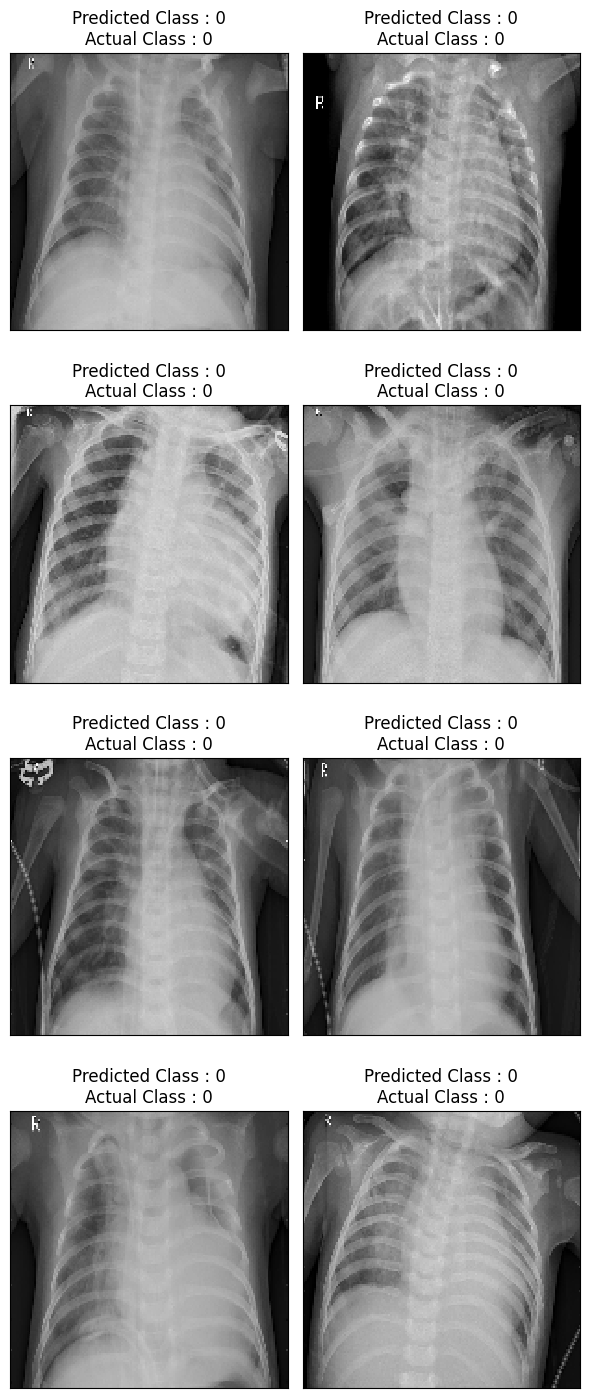

In [49]:
i = 0
plt.figure(figsize=(6,15))
for c in correct[10:18]:
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(150,150), cmap='gray', interpolation='none')
  plt.title(f"Predicted Class : {predictions[c]}\nActual Class : {y_test[c]}")
  plt.tight_layout()
  i += 1

#Some Incorrectly Predicted Classes

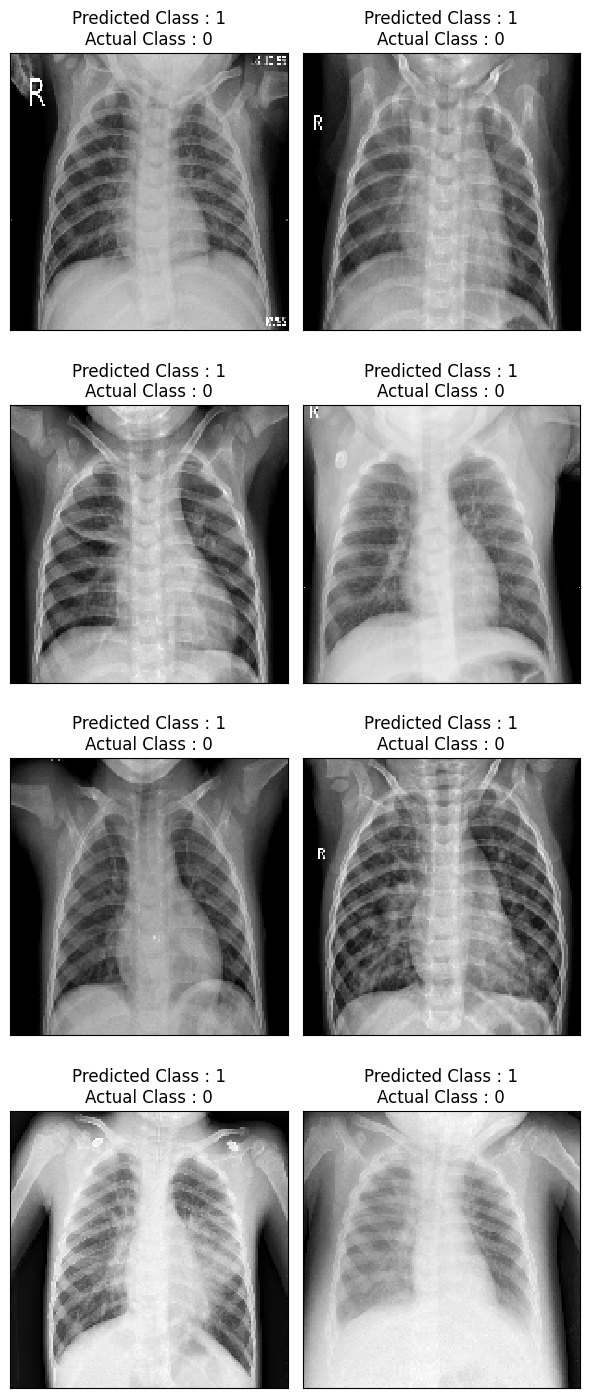

In [50]:
i = 0
plt.figure(figsize=(6,15))
for c in incorrect[10:18]:
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(150,150), cmap='gray', interpolation='none')
  plt.title(f"Predicted Class : {predictions[c]}\nActual Class : {y_test[c]}")
  plt.tight_layout()
  i += 1